<b><font size=7><center> 
    Исследование  результатов А/В теста</center></font></b>


### Описание проекта

Мы сотрудничаем с магазином по продаже вязанных изделий "Утепляйся", т.к. скоро зима и клиентский поток увеличится, а наш магазин хочет увеличить объём продаж и сделать процесс покупки для покупателей максимально комфортным маркетологи подготовили совместно с разработчиками несколько изменений для тестирования.

Полученные нами данные А/В теста содержат 2 файла:

**1 Файл с заказами**
- transactionId — номер заказа;
- visitorId — пользователь совершивший заказ;
- date — дата заказа;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

**2 Файл с визитами**
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в каждой группе A/B-теста

**Необходимо:**

Проанализировать результаты А/В-теста, принять решение по его результатам (продолжить тест или остановить - в связи с победой одной из групп или в связи с отсутствием различий в метриках между группами)

Для принятия решения:
1. построим графики кумулятивной выручки и кумулятивного среднего чека, кумулятивной конверсии по группам
2. посчитаем 95-й и 99-й перцентили количества заказов и  стоимости заказов на пользователя
3. посчитаем статистическую значимость различий в конверсии и в среднем чеке заказа между группами

На основе описанных выше расчётов сделаем выводы и примем решение о дальнейшем продолжении или остановке теста

## Первоначальная обработка полученных данных



### Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math as mth
import datetime as dt
import scipy.stats as stats

from scipy import stats as st

In [2]:
path ='C:\\Users\\anech\\Desktop\\Учёба\\Яндекс_практикум\\DataSets\\'

try:        
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
    
                        
except:    
    orders = pd.read_csv(path + 'orders.csv')
    visitors = pd.read_csv(path + 'visitors.csv')

In [3]:
orders.name = 'orders'
visitors.name = 'visitors'

убеждаемся в корректности отражения содержимого

In [4]:
files_for_work = [orders, visitors]

for i in files_for_work:
    display(i.head(3))
    display(i.describe())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


In [5]:
# приводим заголовки столбцов к нижнему регистру
for i in files_for_work:
    i.columns = [x.lower() for x in i.columns]

In [6]:
# проверяем форматы данных
for i in files_for_work:
    i.info()
    print('-------------------')
    print('')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionid  1197 non-null   int64 
 1   visitorid      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
-------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
-------------------



---

необходимо привести даты к корректному формату

In [7]:
# приводим данные к формату datetime
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

# проверяем
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Данные загружены и отражены корректно, проведём EDA

### Исследование данных

Для того, чтоб результаты исследования были корректными необходимо проверить нет ли пользователей одновременно попавших в обе группы

In [8]:
#найдём пользователей, попавших в 2 группы
duplicated_users = orders.groupby('visitorid').agg({'group': ['nunique', 'unique']})
duplicated_users.columns = ['groups', 'group_names']

duplicated_users = duplicated_users.query('groups > 1')
print('в обе группы попали', len(duplicated_users), "пользователей, что составляет",
      round(len(duplicated_users)/len(orders['visitorid'].unique()) * 100, 2),'% от всей выборки' )

в обе группы попали 58 пользователей, что составляет 5.63 % от всей выборки


т.к. 5% - это уже слишком много, выделим отдельный фрейм, с пользователями попавшими только в одну группу, чтоб дополнительно оценить результаты теста, т.к. "повторные" пользователи могли оказать существенное влияние на результаты

Такое распределение пользователей говорит о некорректности настроек теста, необходимо сообщить инженерам и приложить фрейм с пользователями, попавшими более, чем в одну группу - "duplicated_users"

In [9]:
duplicated_users.head(2)

,groups,group_names
visitorid,,
8300375,2,"[B, A]"
199603092,2,"[A, B]"


In [10]:
orders_clear = orders.query('visitorid not in @duplicated_users.index')
orders_clear.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


---
проверим, на всякий случай, нет ли задвоений заказов 

In [11]:
orders.groupby('transactionid').agg({'visitorid':'count'}).sort_values(by=['visitorid'], ascending=False).head(3)

,visitorid
transactionid,
1062393,1
2883105032,1
2875229767,1


проверим дубликаты

In [12]:
orders[['visitorid','date', 'revenue']].duplicated().sum()

3

In [13]:
orders[orders[['visitorid','date', 'revenue']].duplicated() == True]

,transactionid,visitorid,date,revenue,group
558,3621273697,3941503500,2019-08-06,4990,B
682,1216533772,4266935830,2019-08-29,78990,B
972,2419539947,2587333274,2019-08-08,3600,B


In [14]:
orders[orders.visitorid == 3941503500]

,transactionid,visitorid,date,revenue,group
556,571224785,3941503500,2019-08-06,4990,B
558,3621273697,3941503500,2019-08-06,4990,B


выявлено 3 строки-дубликата, совпадающих по столбцам 'visitorid','date', 'revenue', впринципе вполне возможно, что какой-то клиент сделал заказ дважды в день на одну и ту же сумму, это не притично для нашего объёма данных

In [15]:
visitors.duplicated().sum()

0

прверим кол-во групп, участвующих в тесте

In [16]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [17]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

---
посмотрим за какой период отражены данные в датасетах orders и visitors

In [18]:
# функция для просмотра временного периода данных
def time_period(df, columns):
    print(f'Временной интервал данных таблицы {df.name}: ' +
          f'{df[columns].dt.date.min()} - {df[columns].dt.date.max()}')

time_period(orders, 'date')
time_period(visitors, 'date')

Временной интервал данных таблицы orders: 2019-08-01 - 2019-08-31
Временной интервал данных таблицы visitors: 2019-08-01 - 2019-08-31


---
посмотрим количественное распределение выручки по группам теста

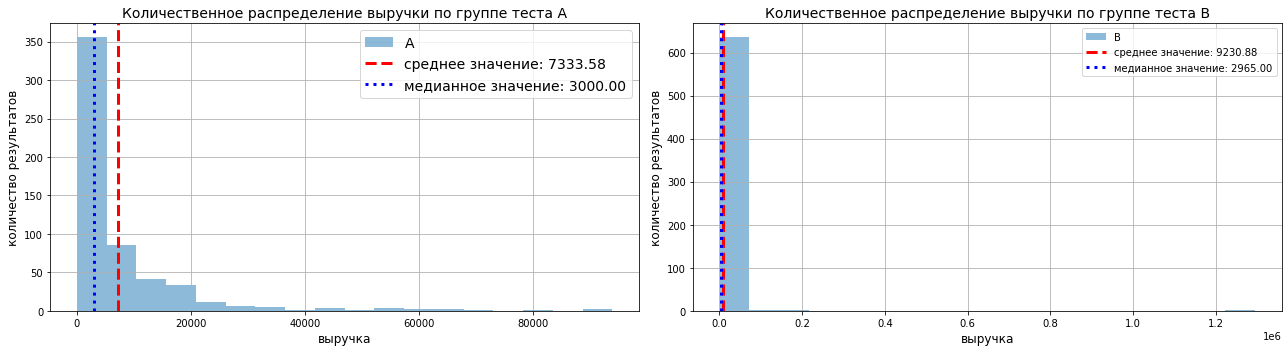

In [86]:
plt.figure(figsize=(18, 5)) # задаём размер сетки для графиков
for i, unit in enumerate(orders.sort_values('group', ascending=True)['group'].unique()):  # выбираем уникальные значения каналов и сохраняем их кол-во в i
    data_var = orders.query('group == @unit').sort_values('revenue', ascending=True)  # на каждом шаге берем данные по 1 каналу
    
    # для наглядности выводим гистограммы в subplot. Параметр позиции вывода берем +1, т.к. индексы в i идут с 0
    data_var['revenue'].hist(bins=18, alpha=0.5, label=unit,  ax=plt.subplot(1, 2, i + 1))
    
    # рисуем отметку среднего + выводим его количественное значение
    plt.axvline(data_var['revenue']. \
                describe()['mean'], color='red', linestyle='dashed', linewidth=3, label='среднее значение: {:.2f}'. \
                format(data_var['revenue'].describe()['mean']))
    
    # рисуем отметку медианы + выводим ее количественное значение
    plt.axvline(data_var['revenue']. \
                describe()['50%'], color='b', linestyle='dotted', linewidth=3, label='медианное значение: {:.2f}'. \
                format(data_var['revenue'].describe()['50%']))
    
    plt.legend(fontsize=14)
    plt.title(f'Количественное распределение выручки по группe теста {unit}', fontsize = 14)
    plt.xlabel('выручка', fontsize = 12)
    plt.ylabel('количество результатов', fontsize = 12)
plt.legend()
plt.tight_layout()
plt.show()

- и в одном и во втором распределениях присутствуют значительные выбросы, которые смещают среднее.
- в группе B хвост гораздо "жирнее", влияние выбросов на данные будет значительнее.
- этот момент необходимо обязательно учесть в ходе исследования.

### Вывод

1. Данные загружены и отражены корректно
2. Временной интервал данных в таблицах отражён за период с 2019-08-01 по 2019-08-31
3. в результатах теста обнаружены пользовтели, попавшие в обе группы, они составляю 5,63% от общего числа пользователей - это слишком много, необходимо обсудить с разработчиками настройки теста
4. дубликатов в данных не обнаружено
5. пользователи поделены на 2 группы в соответствии с условиями теста
6. в данных о выручке присутсвуют значительные вбросы, а следовательно распределение смещённое

## Анализ данных A/B-теста



###  Проанализируем A/B-тест

In [20]:
# сгруппируем данные по группам, посмотрим долю клиентов, совершивших заказ в каждой группе
data_orders = (
    orders.groupby('group', as_index=False)
    .agg({'visitorid': 'count', 'revenue': 'sum'})
    ).rename(columns = {'visitorid':'amount_orders'}) 

data_orders = (
    data_orders.join(visitors.groupby('group')
                                .agg({'visitors': 'sum'}), on = 'group')
                                .rename(columns = {'visitors':'amount_visitors'}) 
)

data_orders['ordersToVisitorsRatio'] = (
    data_orders['amount_orders'] / data_orders['amount_visitors']
    ).map(lambda x: "{0:.4f}".format(x))

data_orders

,group,amount_orders,revenue,amount_visitors,ordersToVisitorsRatio
0,A,557,4084803,18736,0.0297
1,B,640,5907760,18916,0.0338


___
Проверим гипотезу о равенстве долей заказов в группах А и В


**Нулевая гипотеза** в группах А и В равные доли заказов, **альтернативная гипотеза** - в группах A и B  доли заказов различны

Если пропорции равны, разница между ними будет равна нулю. Посчитаем, как далеко статистика "уехала" от нуля. Какова вероятность получить такое отличие или больше? Так как распределение статистики нормальное, вызовем метод cdf(). Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака, это возможно, потому что тест двусторонний, по этой же причине удваиваем результат

In [21]:
alpha = 0.05  # критический уровень статистической значимости

#пропорция успехов в группе A:
group_a = data_orders.loc[0, 'amount_orders'] / data_orders.loc[0, 'amount_visitors']
#пропорция успехов в группе B:
group_b = data_orders.loc[1, 'amount_orders'] / data_orders.loc[1, 'amount_visitors']
#пропорция успехов в комбинированном датасете:
groups_combined = ((data_orders.loc[0, 'amount_orders'] + data_orders.loc[1, 'amount_orders']) /
    (data_orders.loc[0, 'amount_visitors'] + data_orders.loc[1, 'amount_visitors']))
#разница пропорций в датасетах
difference = group_a - group_b 

#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(groups_combined * (1 - groups_combined) * 
                                (1 / data_orders.loc[0, 'amount_visitors'] + 1 / data_orders.loc[1, 'amount_visitors']))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  


p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)

if p_value < alpha:# ваш код
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.02320723394441848
Отвергаем нулевую гипотезу: между долями есть значимая разница


# Вывод

Доля заказов в группе B выше, чем в группе А на 0.4%, эту разницу можно признать статистически значимой

### Построим график кумулятивной выручки по группам

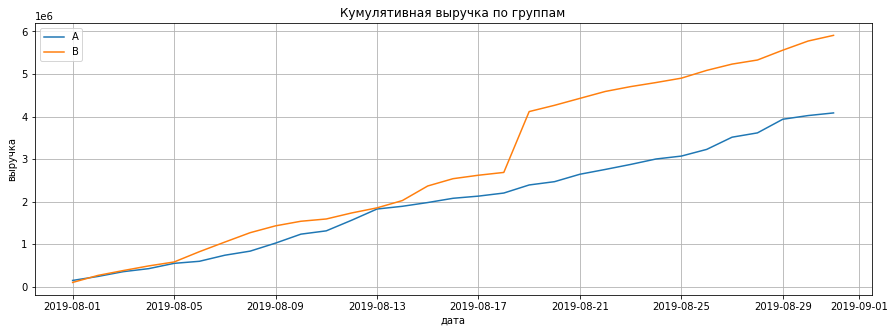

In [22]:
#создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

#получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'transactionid' : 'nunique', 'visitorid' : 'nunique', 'revenue' : 'sum'}
            ), axis=1).sort_values(by=['date','group'])

#получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1
    ).sort_values(by=['date','group'])

#объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData
# Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

#датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
#датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

#Строим график выручки группы А
fig, ax = plt.subplots(figsize = (15,5))
ax = plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

#Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.grid()
plt.title('Кумулятивная выручка по группам')
plt.ylabel('выручка')
plt.xlabel('дата');

Выручка увеличивается равномерно почти в течение всего теста, это хороший знак

Резкие колебания на графике могут быть связаны с аномальными покупками - либо одна большая, либо чек, приближенный к среднему,  но при этом увеличилось кол-во чеков

Проверми предположение

In [23]:
# посмотрим агрегированные данные по продажам по группам
cumulativeData.query('date >= "2019-08-16"').head(12)

,date,group,orders,buyers,revenue,visitors
30,2019-08-16,A,301,277,2078908,10047
31,2019-08-16,B,359,336,2539635,10013
32,2019-08-17,A,311,283,2129769,10459
33,2019-08-17,B,373,349,2620790,10434
34,2019-08-18,A,328,300,2202167,11127
35,2019-08-18,B,382,357,2686621,11171
36,2019-08-19,A,350,320,2391910,11629
37,2019-08-19,B,403,377,4116541,11658
38,2019-08-20,A,362,330,2469529,12204
39,2019-08-20,B,423,396,4263815,12218


18.08 сумма продаж по группе B сильно возрасла, не пропорционально увеличению кол-ва чеков, посмотрим детализированные данные по продажам

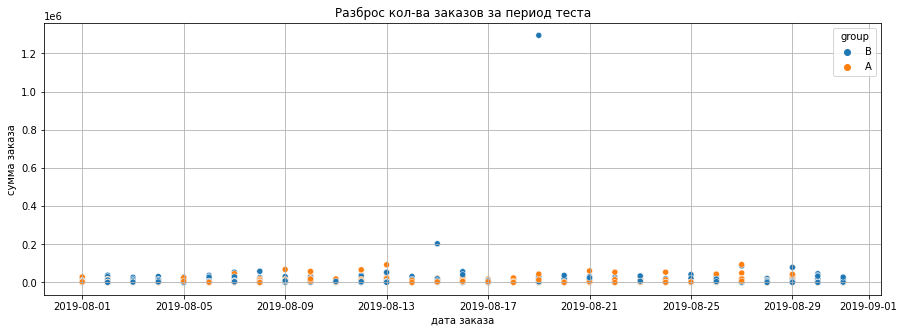

In [24]:
# посмотрим покупки по дням
fig, ax = plt.subplots(figsize = (15,5))
ax = sns.scatterplot(x='date', y='revenue', data=orders, hue='group')
plt.grid()
plt.title('Разброс кол-ва заказов за период теста')
plt.ylabel('сумма заказа')
plt.xlabel('дата заказа');
plt.show()


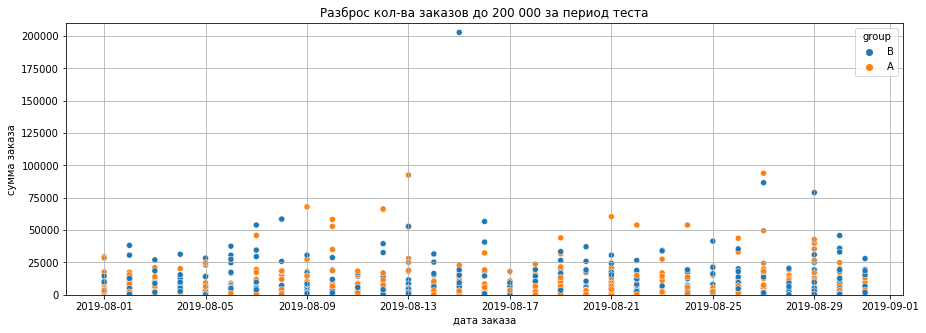

In [25]:
# изменим масштаб, для более детального анализа
fig, ax = plt.subplots(figsize = (15,5))
ax = sns.scatterplot(x='date', y='revenue', data=orders, hue='group')
plt.grid()
plt.ylim(0, 210000);
plt.title('Разброс кол-ва заказов до 200 000 за период теста')
plt.ylabel('сумма заказа')
plt.xlabel('дата заказа')
plt.show();

# Вывод

С начала теста до 5.08 кумулятивная выручка по дням по двум группам была почти равной, с 5.08 группа В нарастила выручку и начала лидировать до 13.08, когда по причине больших покупок две группы сравнялись в выручке (предположительно большие чеки 12 и 13.08 по группе А попадут в группу аномальных, проверим это предположение далее), после этого дня группа В ежедневно укрепляла своё лидерство перед группой А

19.08 пик отражает аномально крупную покупку  по группе B, что это лидерство стабильно

### Построим график кумулятивного среднего чека по группам

In [26]:
cumulativeRevenueA.head()

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


<a id="кумулятивныйсрчек"></a>

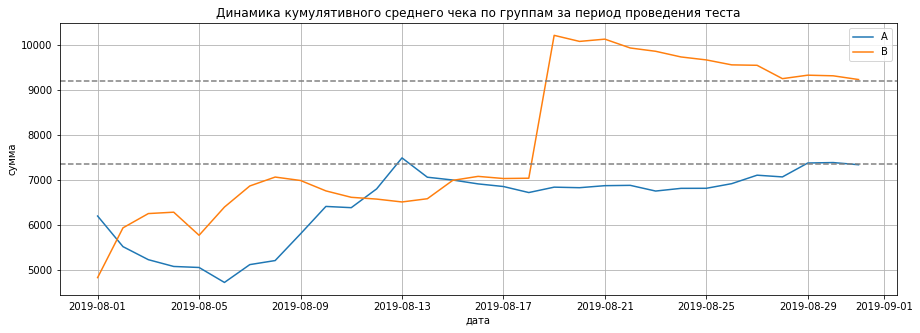

In [27]:
# для построения графика по группам считаем динамику отношения кумулятивной выручки к кумулятивному количеству заказов по дням
fig, ax = plt.subplots(figsize = (15,5))
ax = plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.axhline(y=9200, color='gray', linestyle='--')
plt.axhline(y=7350, color='gray', linestyle='--')
plt.title('Динамика кумулятивного среднего чека по группам за период проведения теста')
plt.ylabel('сумма')
plt.xlabel('дата')
plt.legend()
plt.grid();

# Вывод
Кумулятивный средний чек по группам более волотилен, нежели кумулятивная выручка, ожидаемо по мере увеличения объёма данных динамика колебаний снижается

Пик 19.08 связан с аномально большим заказом, который мы заметили выше

13 и 14 кумулятивный средний чек по группе А увеличился, что мы и отразилось выше на графике кумулятивной выручки, причина, как мы заметили в предыдущем пункте в нескольких заказах со стоимостью гораздо выше средней

В конце графики среднего чека имеют тенденцию к сближению и по одной и по второй группам

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

In [28]:
cumulativeRevenueA.head(2)

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44


In [29]:
cumulativeRevenueB.head(2)

,date,revenue,orders
1,2019-08-01,101217,21
3,2019-08-02,266748,45


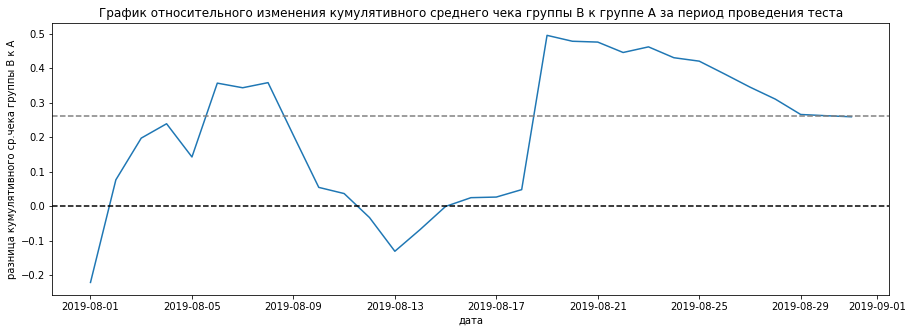

In [85]:
#собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, on='date', how='left', suffixes=['A', 'B'])
#cтроим отношение средних чеков
fig, ax = plt.subplots(figsize = (15,5))
ax = plt.plot(mergedCumulativeRevenue['date'], 
              (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']) /
              (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
#добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A за период проведения теста')
plt.axhline(y=0.26, color='gray', linestyle='--')
plt.ylabel('разница кумулятивного ср.чека группы В к А')
plt.xlabel('дата');

# Вывод
В нескольких точках график различия между сегментами резко «скачет», необходимо проверить крупные заказы и выбросы


### Построим график кумулятивной конверсии по группам

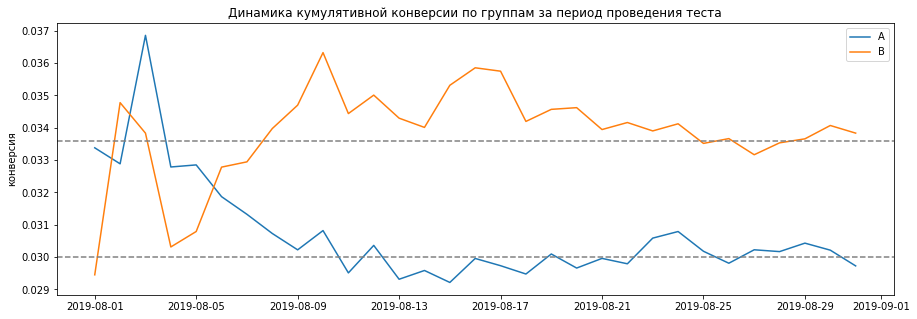

In [84]:
#считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

#отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

#отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

#строим графики
fig, ax = plt.subplots(figsize = (15,5))
ax = plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.axhline(y=0.0336, color='gray', linestyle='--')
plt.axhline(y=0.03, color='gray', linestyle='--')


plt.legend()
plt.title('Динамика кумулятивной конверсии по группам за период проведения теста')
plt.ylabel('конверсия');

# Вывод
Кумулятивная конверсия после 6.08 по группе B вырвалась вперёд и колеблется около одного значения, а конверсия группы B просела и также колеблется вокруг одного значения 

### Построим график относительного изменения кумулятивной конверсии группы B к группе A

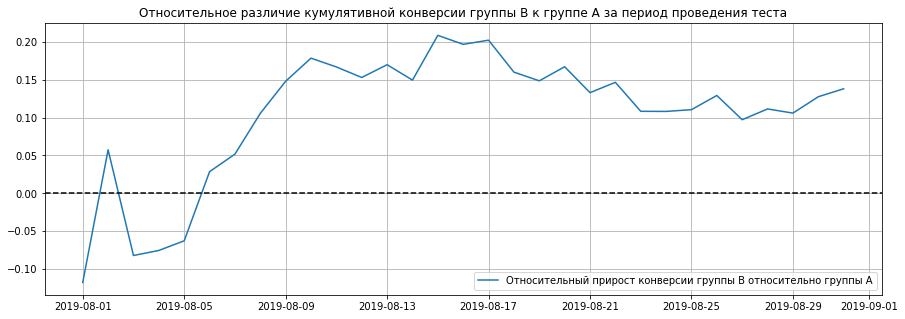

In [82]:
#собираем данные в одном датафрейме
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
fig, ax = plt.subplots(figsize = (15,5))

#cтроим отношение кумулятивной конверсии 
ax = plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
              mergedCumulativeConversions['conversionA']-1, 
              label="Относительный прирост конверсии группы B относительно группы A")

plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.grid()
plt.title('Относительное различие кумулятивной конверсии группы B к группе A за период проведения теста');

# Вывод
В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Потом её конверсия снова падала и снова нарастала по сравнению с группой А

В целом отношение конверсии ещё не установилось, но динамика вокруг одного значения, и сейчас делать какие-либо выводы по тесту сложно, впрочем, стоит проанализировать аномалии, возможно, они изменят картину.

In [33]:
# считаем кол-во заказов по клиентам
ordersByUsers = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'})
)

ordersByUsers.columns = ['visitorid', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(5)

,visitorid,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


Посмотрим для начала на распределение кол-ва заказов

In [34]:
ordersByUsers.head()

,visitorid,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


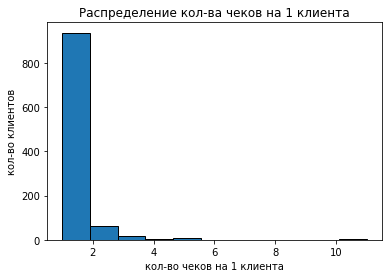

In [74]:
plt.hist(ordersByUsers['orders'], bins=11, ec='black')
plt.title('Распределение кол-ва чеков на 1 клиента')
plt.ylabel('кол-во клиентов')
plt.xlabel('кол-во чеков на 1 клиента');

Посмотрим распределение заказов по пользователям, попавшим только в 1 группу

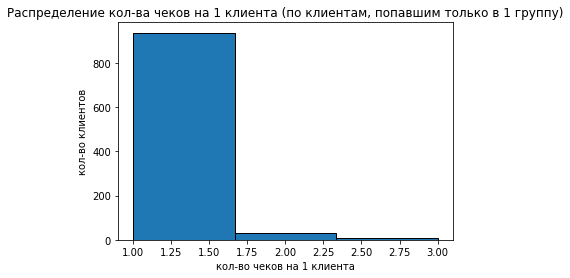

In [75]:
# считаем кол-во заказов по клиентам, которые попали только в 1 группу
ordersByUsers_clear = (
    orders_clear.groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'})
)

ordersByUsers_clear.columns = ['visitorid', 'orders']
ordersByUsers_clear.sort_values(by='orders', ascending=False).head(5)

plt.hist(ordersByUsers_clear['orders'], bins=3, ec='black')
plt.title('Распределение кол-ва чеков на 1 клиента (по клиентам, попавшим только в 1 группу)')
plt.ylabel('кол-во клиентов')
plt.xlabel('кол-во чеков на 1 клиента');

Львиная доля пользователей совершает от одного до 3ёх заказов, пользователей, совершивших более 3 заказов, скорее всего можно отнести к аномальным, необходимо проверить 95 и 99й перцентили, для того, чтоб сделать более точный вывод

В пользу нашего предположения говорит и то, что в очищенных от задвоенных пользователей данных максимальное кол-во заказов - 3

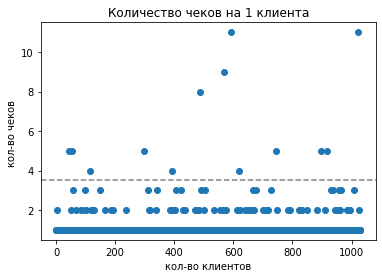

In [37]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.axhline(y=3.5, color='gray', linestyle='--')
plt.title('Количество чеков на 1 клиента')
plt.xlabel('кол-во клиентов')
plt.ylabel('кол-во чеков ');

# Вывод

Много пользователей с 1-3 заказами, их точная доля не ясна, но скорее всего пользователей с кол-вом заказов более 3х можно отнести к аномальным. Необходимо посчитать выборочные перцентили количества заказов на одного пользователя

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [38]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

# вынесем 98 перцентиль в отдельную переменную
orders_98perc = round(np.percentile(ordersByUsers['orders'], [98])[0])
orders_98perc

[1. 2. 4.]


3

Не более 5% пользователей оформляли больше чем 2 заказa. И 10% пользователей делали заказ более одного раза.
Разумно выбрать 2 или 3 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

### Построим точечный график стоимостей заказов

Изучим гистограмму распределения стоимостей заказов:

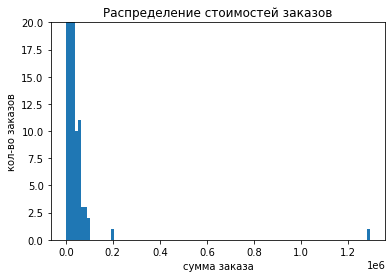

In [77]:
plt.hist(orders['revenue'], bins=100)
plt.ylim(0, 20);
plt.title('Распределение стоимостей заказов')
plt.xlabel('сумма заказа')
plt.ylabel('кол-во заказов');

судя по гистограмме более 99% заказов не превышают 70 000, всё, что выше, скорее всего аномалия

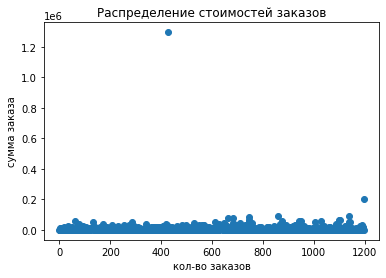

In [40]:
# строим точечный график
x_values = pd.Series(range(0,len(orders)))
plt.scatter(x_values, orders['revenue']);
plt.title('Распределение стоимостей заказов')
plt.ylabel('сумма заказа')
plt.xlabel('кол-во заказов');

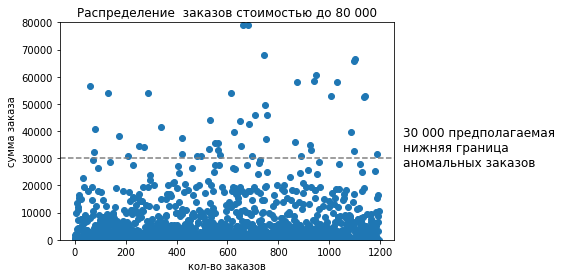

In [41]:
# изменим масштаб графика
x_values = pd.Series(range(0,len(orders)))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 80000)
plt.axhline(y=30000, color='gray', linestyle='--')
plt.title('Распределение  заказов стоимостью до 80 000')
plt.ylabel('сумма заказа')
plt.xlabel('кол-во заказов')

plt.text(1290, 27000, '30 000 предполагаемая \nнижняя граница \nаномальных заказов', fontsize=12);

Всё, как предполагали: есть немного дорогих заказов. По графику можно выбрать границу аномальных заказов примерно от 30 000 рублей, однако посмотрим на расчёт перцентилей

### Посчитаем 95-й и 99-й перцентили стоимости заказов, выберем границу для определения аномальных заказов.

In [42]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

# вынесем 98 перцентиль в отдельную переменную
revenue_98perc = round(np.percentile(orders['revenue'], [98])[0])
revenue_98perc

[18168.  28000.  58233.2]


44133

Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58 234 рублей. 



Граница аномалий - 98ой перцентиль, на наших данных это 44 133 руб, переменная revenue_98perc:
1. 1% это слишком мало, тем более по кол-ву чеков 1% это больше 4ёх, по кол-ву ставить нужно явно от 3ёх
2. если ставить разные перцентили как аномалию по кол-ву чеков и среднему чеку не очень понятно как обуславливать такой выбор
3. если ставить 5%, как говорилось в курсе - отбросим слишком много данных как аномальные

Учитывая вышесказанное, оптимальное решение - брать 98ой перцентиль за границу нормы, остальное считать аномалией



### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

Сформулируем гипотезы. 

**Нулевая**: различий в конверсии между группами нет. **Альтернативная**: различия в конверсии между группами есть.

Выше мы уже убедились о том, что в данных есть аномалии, которые могут существенным образом влиять на поведение метрик, поэтому для проверки гипотез нам необходим непараметрический тест. Проверять гипотезу будем с помощью теста Уилкоксона-Мана-Уитни, он устойчив к выбивающимся значениям и поможет вычислить вероятность получения указанного результата


In [43]:
visitors.head(2)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619


In [44]:
orders.head(2)

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B


In [45]:
# выделяем пользователй группы А в отдельный датафрейм 
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# считаем накопительное кол-во клиентов на каждую дату
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)

visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# производим аналогичные расчёты по группе В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)

visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# считаем кол-во и сумму заказов по группе А за каждый день
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)

ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
# считаем накопительные кол-во и сумму заказов по группе А за каждый день
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# аналогичные расчёты проводим по группе В
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)

ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]


# объединыем полученные ранее таблицы
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

Расшифровка названий столбцов данных:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateВ — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

In [46]:
# формируем таблицу с заказами по группе А
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)

ordersByUsersA.columns = ['userId', 'orders']

# формируем таблицу с заказами по группе В
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)

ordersByUsersB.columns = ['userId', 'orders']

# подготовим выборки к проверке критерием Манна-Уитни
# объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов
# Тем, кто ничего не заказал, будут соответствовать нули
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("p-value {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("разница в комверсии между группами B и А  {0:.2%}".format(sampleB.mean() / sampleA.mean() - 1))

p-value 0.017
разница в комверсии между группами B и А  13.81%


**Вывод:**

oтвергаем нулевую гипотезу: по «сырым» данным есть основания утверждать, что между долями есть значимая разница 

Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет - отвергаем, относительный выигрыш группы B равен 13.8% — второе число в выводе.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

**Нулевая гипотеза**: различий в среднем чеке между группами нет. **Альтернативная гипотеза**: различия в среднем чеке между группами есть.

In [47]:
print('Значение p-value {0:.3f}'
      .format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Средний чек в группах B и А различается на {0:.2%}'
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Значение p-value 0.729
Средний чек в группах B и А различается на 25.87%


P-value значительно больше 0.05. 

Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A. 

Необходимо так же посмотреть как будут себя вести очищенные данные

### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным

Примем за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 35 000 рублей. Так мы уберём 2% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 4 — usersWithManyOrders и пользователей, совершивших заказы дороже 35 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.



In [48]:
orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [49]:
ordersByUsersA.head()

,userId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [50]:
# подготавливаем таблицы, c пользователями,сделавшими более 98 перцентиля заказов и заказы с суммой более 98 перцентиля
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_98perc]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_98perc]['userId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > revenue_98perc]['visitorid']

# конкатенируем таблицы в единый фрейм с аномальными пользователями
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

display(abnormalUsers.head(5))
print('аномальных пользователей', abnormalUsers.shape[0])

1099    148427295
18      199603092
23      237748145
1137    759473111
949     887908475
dtype: int64

аномальных пользователей 29


In [51]:
# посчитаем долю аномальных пользователей
unique_castomers = len(orders.groupby('visitorid').agg({'transactionid':'count'}))
abnormalUsers.shape[0]/unique_castomers

0.028128031037827354

Всего 29 аномальных пользователя, они оставляют 3% от первоначального кол-ва. Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. 



In [52]:
# подготовим выборки количества заказов по пользователям по группам теста

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [53]:
print('Значение p-value на очищенных данных {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Разница в комверсии между группами B и А {0:.2%}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
if p_value < alpha:# ваш код
    print('Отвергаем нулевую гипотезу: между конверсиями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии по группам А и В разными'
    )

Значение p-value на очищенных данных 0.010
Разница в комверсии между группами B и А 16.08%
Отвергаем нулевую гипотезу: между конверсиями есть значимая разница


Результаты по конверсии не сильно изменились.

По-прежнему p-value меньше 0.05 и оно снизилось по сравнению с сырыми данными, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем, относительный выигрыш группы B повысился на очищенных данных и равен 16.1% 

# проведём аналогичные расчёты, с данными, очищенными от  пользователей, попавших в обе группы

In [54]:
duplicated_users = duplicated_users.reset_index()
duplicated_users.head(2)

,visitorid,groups,group_names
0,8300375,2,"[B, A]"
1,199603092,2,"[A, B]"


In [55]:
# подготавливаем таблицы, c пользователями,сделавшими более 3 заказов и заказы с суммой более 35 тыс и пользователями,
# попавшими в 2 группы 
usersWithManyOrders_clear = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_98perc]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_98perc]['userId'],
        duplicated_users['visitorid']
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > revenue_98perc]['visitorid']

# конкатенируем таблицы в единый фрейм
abnormalUsers_clear = (
    pd.concat([usersWithManyOrders_clear, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

display(abnormalUsers_clear.head(5))
print('аномальных пользователей', abnormalUsers_clear.shape[0])

0         8300375
1099    148427295
18      199603092
2       232979603
23      237748145
dtype: int64

аномальных пользователей 76


In [56]:
usersWithManyOrders.head()

18      199603092
23      237748145
227    2038680547
269    2378935119
278    2458001652
Name: userId, dtype: int64

In [57]:
# подготовим выборки количества заказов по пользователям по группам теста
sampleAFiltered_clear = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers_clear))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


sampleBFiltered_clear = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers_clear))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [58]:
print('Значение p-value на данных очищенных в т.ч. от пользователей, попавших в обе группы {0:.3f}'
      .format(stats.mannwhitneyu(sampleAFiltered_clear, sampleBFiltered_clear)[1]))
print('Разница в комверсии между группами B и А {0:.2%}'.format(sampleBFiltered_clear.mean()/sampleAFiltered_clear.mean()-1))

Значение p-value на данных очищенных в т.ч. от пользователей, попавших в обе группы 0.007
Разница в комверсии между группами B и А 17.48%


<a id="конверсия_проверка_гипотезы"></a>

# Вывод

Результаты по конверсии не сильно изменились.

По-прежнему p-value меньше 0.05 и оно снизилось по сравнению с сырыми данными, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем, относительный выигрыш группы B повысился на данных очищенных от аномалий и повторных пользователей и равен 17.5%

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [59]:
orders.head(2)

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B


In [60]:
print(
    'Значение p-value на очищенных данных {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Средний чек в группах B и А различается на {0:.2%}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

Значение p-value на очищенных данных 0.768
Средний чек в группах B и А различается на 4.05%


P-value увеличился, но и разница между сегментами очень сильно сократилась с 26% до 4.1%, по-прежнему нет причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия



# проведём аналогичные расчёты, с данными, очищенными от  пользователей, попавших в обе группы

In [61]:
print(
    'Значение p-value на данных очищенных, в т.ч. от пользователей, попавших в обе группы {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers_clear)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers_clear)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Средний чек в группах B и А различается на {0:.2%}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers_clear)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers_clear)),
            )
        ]['revenue'].mean()
        - 1
    )
)

Значение p-value на данных очищенных, в т.ч. от пользователей, попавших в обе группы 0.895
Средний чек в группах B и А различается на 2.83%



<a id="срчекпроверкагипотезы"></a>

# Вывод

P-value увеличился, но и разница между сегментами очень сильно сократилась до 2.8% на полностью очищенных от аномалий и повторных пользователей данных

Значит, по-прежнему нет причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия

Хотя общие выводы по результатам теста не изменились, мы видим, как сильно аномалии повлияли на результаты A/B-теста

## Вывод проекта

**Исходя из обнаруженных фактов, тест следует остановить и признать его успешным.** Продолжать смысла нет, потому как вероятность, что при имеющихся данных сегмент B на самом деле лучше сегмента A — очень высока.

- Есть основания утверждать, что существует статистически значимое различие по конверсии между группами и по «сырым», и по данным после полной фильтрации аномалий, группа B выигрывает группу А на 16.8% по очищенным данным и на 13% по полным данным [результаты проверки](#конверсия_проверка_гипотезы);
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий [результаты проверки](#срчекпроверкагипотезы);
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A и есть тенденция к улучшению:
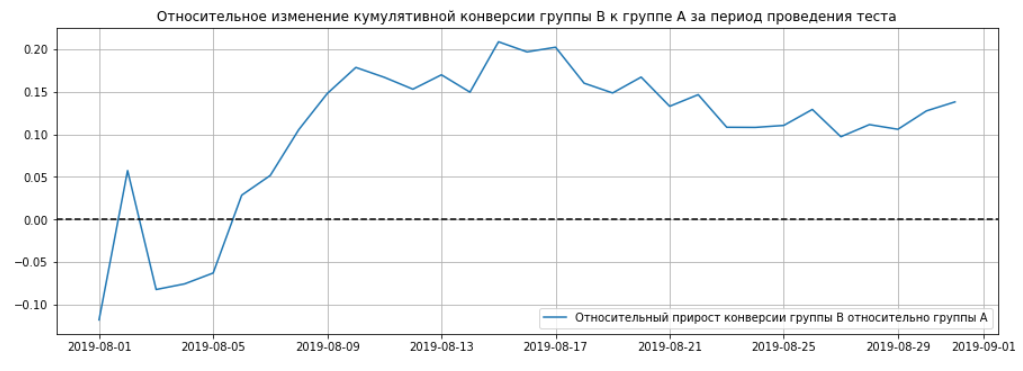

- График различия среднего чека показывает и сильные колебания и говорит о том, что результаты не установились на каком-то более-менее стабильном уровне, хотя результаты группы B сейчас почти на 26% лучше:
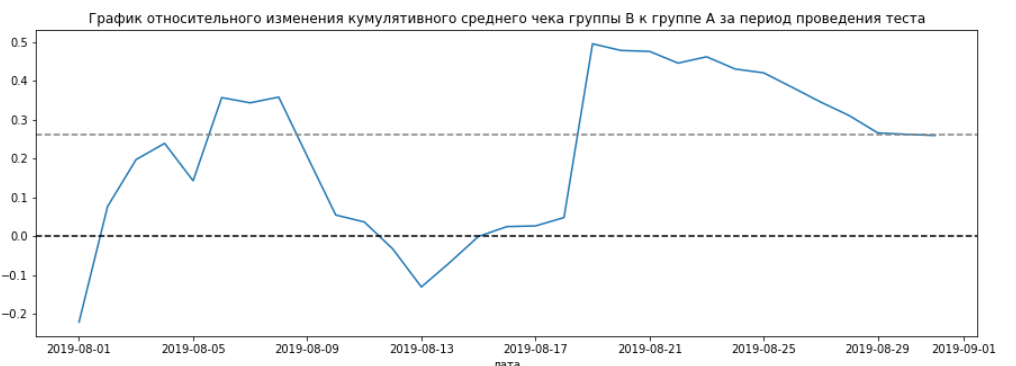

- Следует обратить внимание на то, что тестируемая гипотеза оказала влияние на конверсию, а следовательно на повышение выручки. При этом несмотря на то, что на последнюю дату тестирования кумулятивный средний чек по группе В на 26% выше, [графики кумулятивного среднего чека имеют тенденцию к сближению](#кумулятивныйсрчек), причина текущего различия - вбросы, об этом нам и говорят результаты проверки гипотезы о равенстве критерием Мана-Уитни, нет оснований утверждать, что в средних чеках по группам есть различия